In [344]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from collections import defaultdict

# plot settings
mpl.rcParams["figure.dpi"] = 200
mpl.rcParams["legend.fontsize"] = 12
mpl.rcParams["font.size"] = 13
mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.alpha"] = 0.3
mpl.rcParams["axes.axisbelow"] = True

TEX_PLOTS = True

if TEX_PLOTS:
    plt.rc("text", usetex=True)
    plt.rc("text.latex", preamble=r"""
     \usepackage{palatino}
     \usepackage{newpxmath}""")
else:
    plt.rc("text", usetex=False)
    
plt.rc("font", family="serif")

In [345]:
# data generated by running the following command in this directory:
#  $ ./run_model.py data/time_steps_data.npz --repetitions=75 --n-cores=4 --collect-timeseries=True --time-steps=5000
# which took about 1 hour on my shitty 2016 macbook
data = np.load("data/time_steps_data.npz", allow_pickle=True)
dfs = [pd.DataFrame.from_dict(d) for d in data["results"]]
t = len(dfs[0])

In [346]:
n_extinctions = 0
for df in dfs:
    if df["Ant Biomass"].iloc[-1] == 0:
        n_extinctions += 1
print(f"{n_extinctions} out of {len(dfs)} runs went extinct")

46 out of 75 runs went extinct


## Statistics plots

In [347]:
concat_df = pd.concat(dfs)
grouped_df = concat_df.groupby(level=0)
means_df = grouped_df.mean()
std_df = grouped_df.std()

In [348]:
cols = ("Fungus Biomass", "Ant Biomass", "Fraction forager ants")
colors = ("black", "tab:brown", "tab:red")

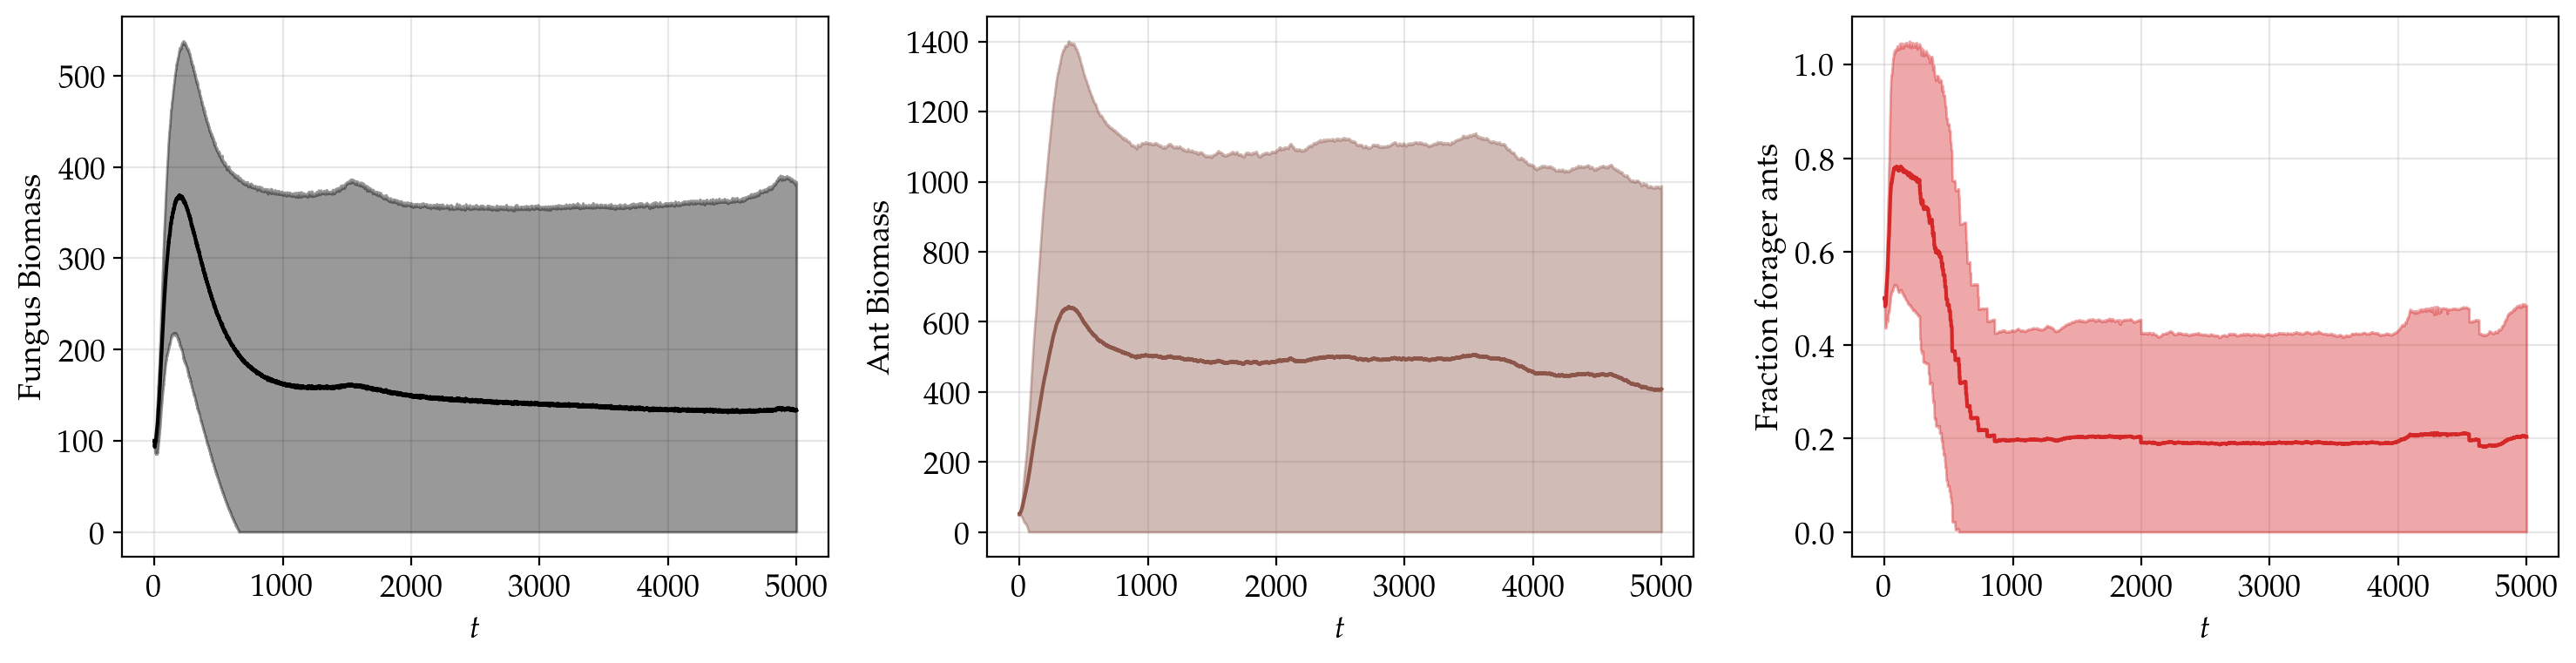

In [349]:
fig = plt.figure(figsize=(15, 4))

for i, (measure, color) in enumerate(zip(cols, colors)):
    ax = fig.add_subplot(1, 3, i+1)
    ax.plot(range(t), means_df[measure], label=measure, color=color)
    mean_min_std = means_df[measure] - std_df[measure]
    mean_min_std[mean_min_std < 0] = 0
    
    ax.fill_between(range(t),
                    mean_min_std, means_df[measure] + std_df[measure],
                    alpha=0.4, color=color)
    ax.set_xlabel("$t$")
    ax.set_ylabel(f"{measure}")
    
plt.tight_layout()
plt.show()

In [350]:
final_measures = defaultdict(list)

# some pandas magician might be able to figure out how to do this more beautifully, but I sure am not
for measure in cols:
    for df in dfs:
        final_measures[measure].append(df[measure].iloc[-1])

final_measures_df = pd.DataFrame.from_dict(final_measures)

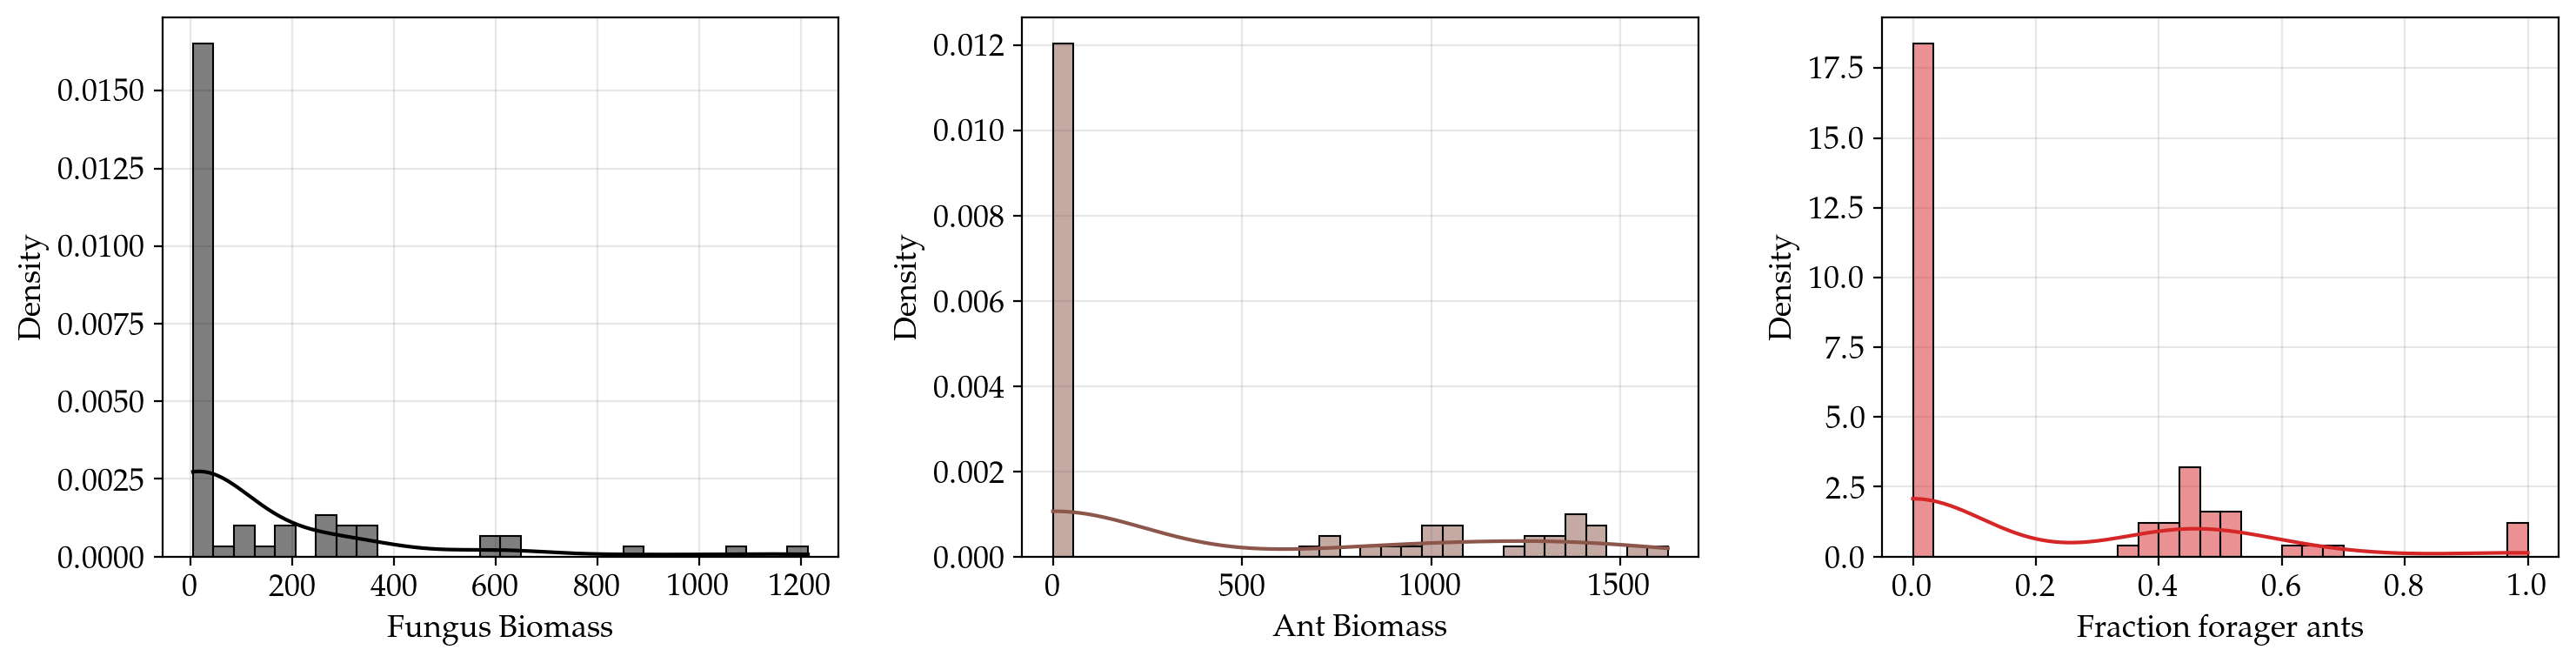

In [372]:
fig = plt.figure(figsize=(15, 4))

for i, (measure, color) in enumerate(zip(cols, colors)):
    ax = fig.add_subplot(1, 3, i+1)
    g = sns.histplot(data=final_measures_df, x=measure, alpha=0.5, bins=30, ax=ax, color=color, kde=True, stat="density")
    ax.set_ylabel("Density")
    #ax.set_title(f"Final {measure} Distribution")

plt.tight_layout()
plt.show()

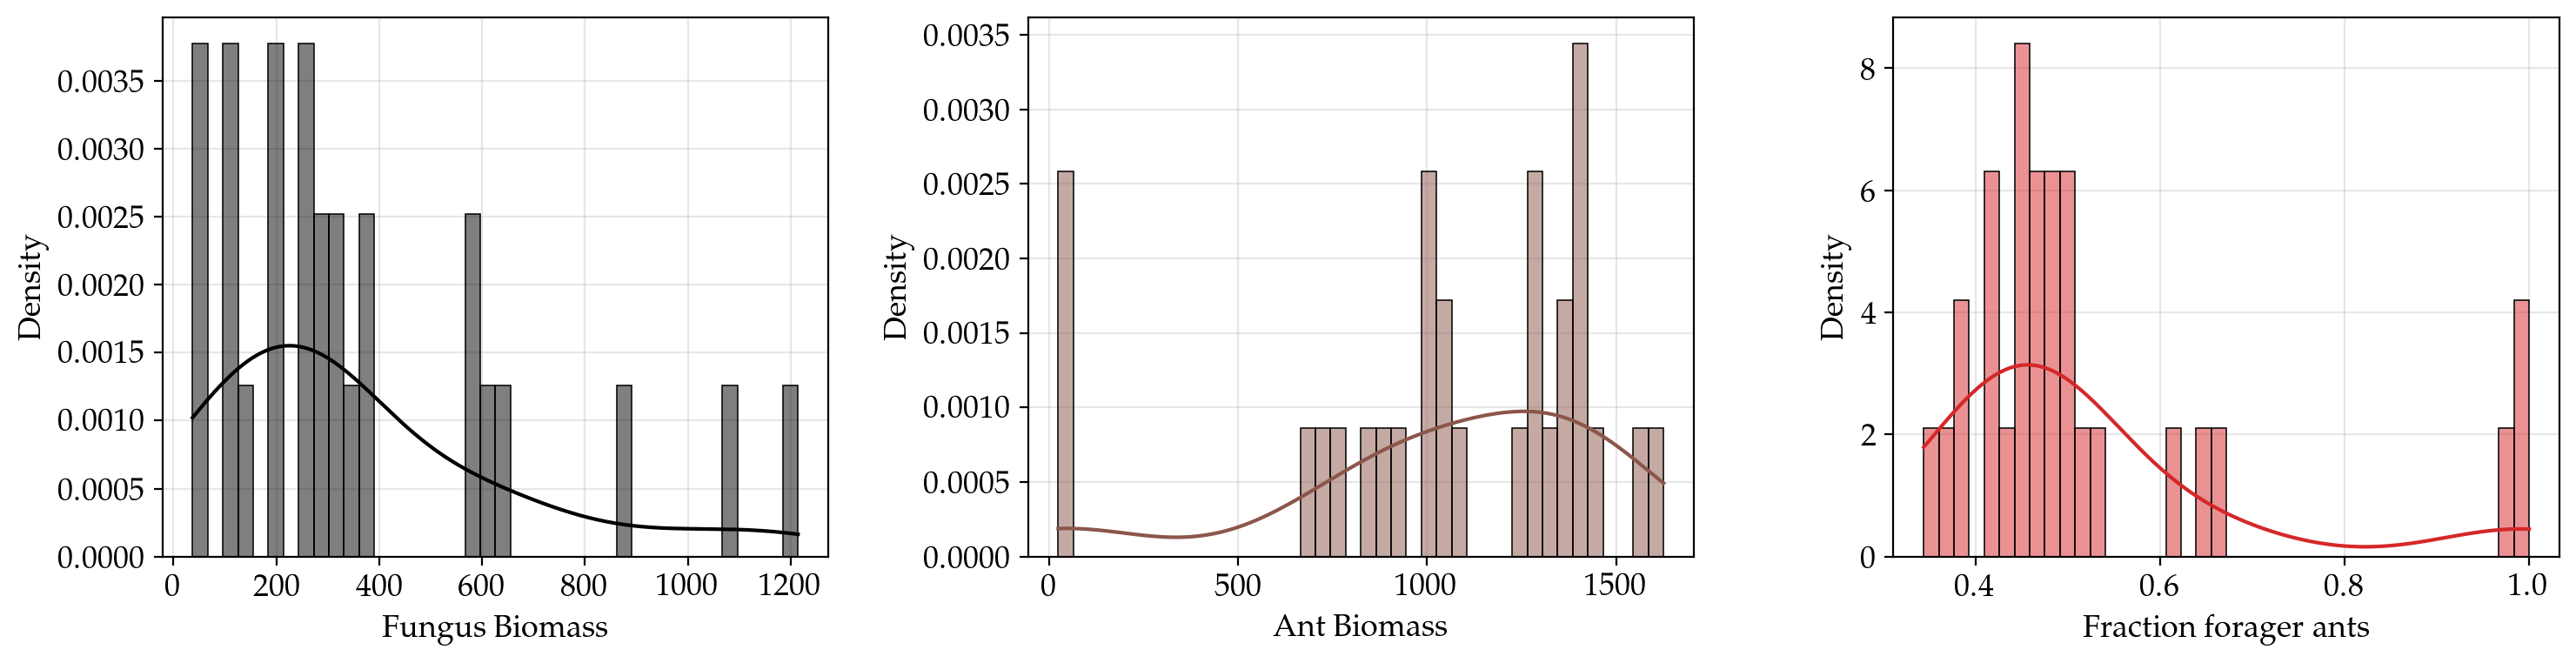

In [371]:
fig = plt.figure(figsize=(15, 4))

final_measures_df_filtered = final_measures_df

for i, (measure, color) in enumerate(zip(cols, colors)):
    # filter zeros
    if measure == "Fungus Biomass":
        # < 5 is a dead fungus!
        filtered_df = final_measures_df[measure].loc[~(final_measures_df[measure] < 5)]
    else:
        filtered_df = final_measures_df[measure].loc[~(final_measures_df[measure] == 0)]
        
    ax = fig.add_subplot(1, 3, i+1)
    g = sns.histplot(data=filtered_df, alpha=0.5, bins=40, ax=ax, color=color, kde=True, stat="density")
    ax.set_ylabel("Density")
    #ax.set_title(f"Final {measure} Distribution")

plt.tight_layout()
plt.show()

## Individial run

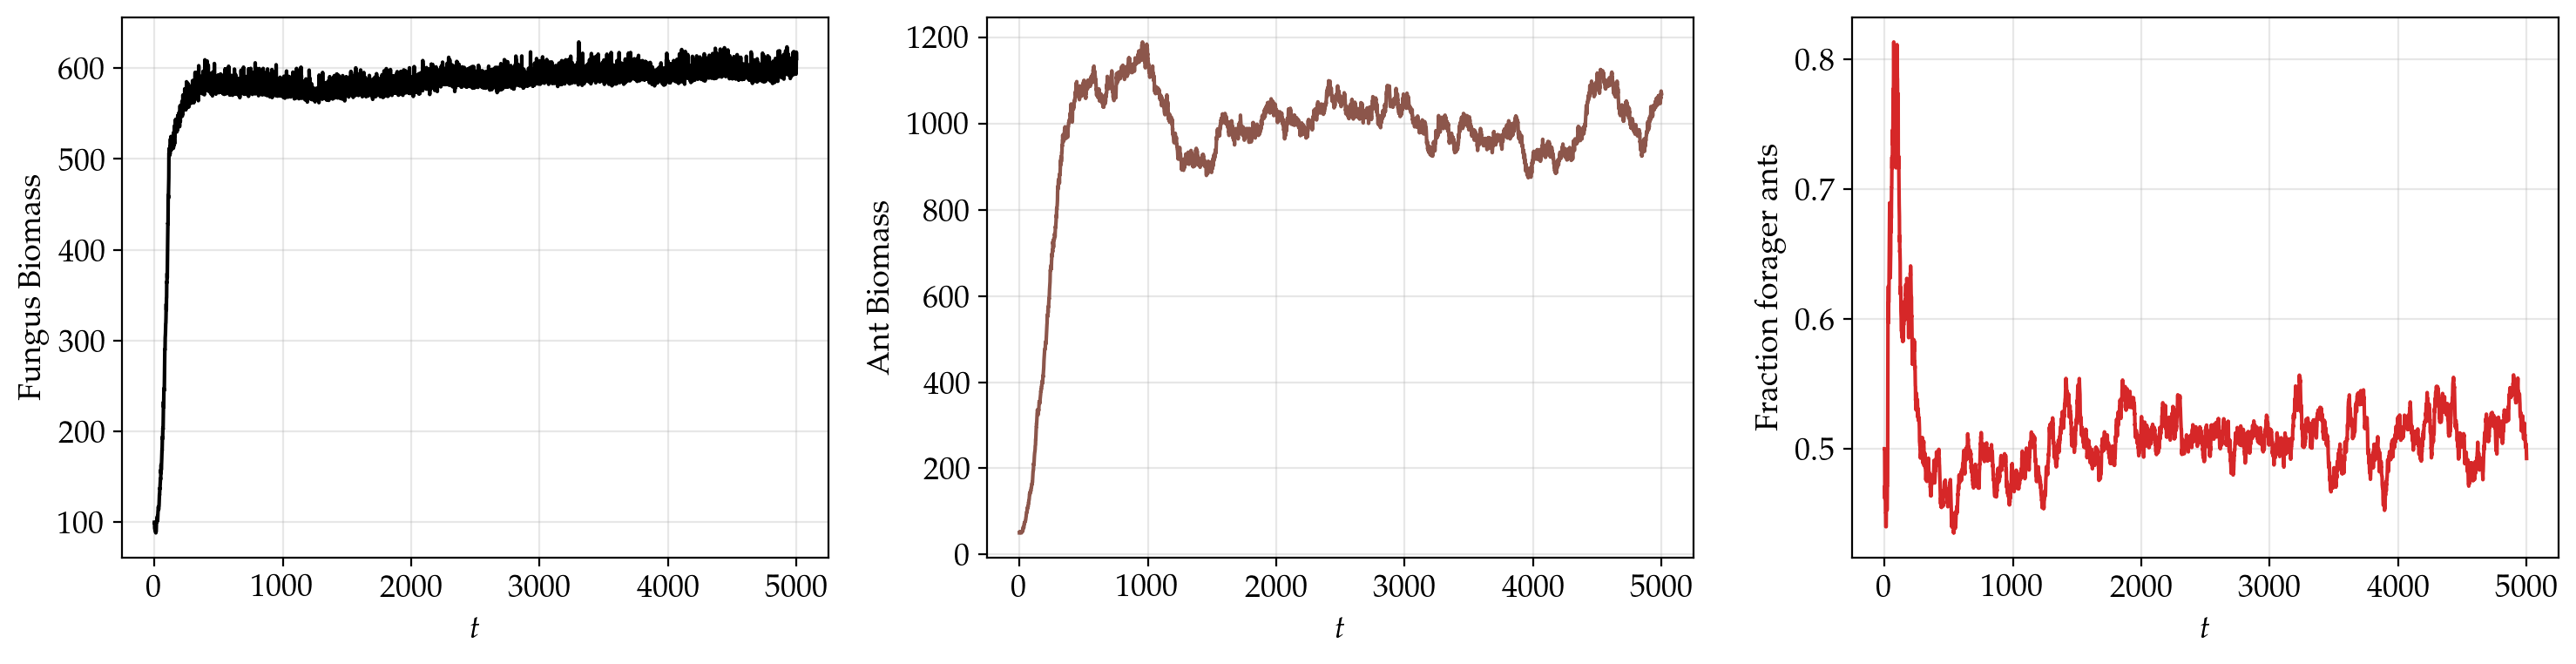

In [355]:
run = 33
fig = plt.figure(figsize=(15, 4))

for i, (measure, color) in enumerate(zip(cols, colors)):
    ax = fig.add_subplot(1, 3, i+1)
    ax.plot(range(t), dfs[run][measure], label=measure, color=color)
    ax.set_ylabel(f"{measure}")
    ax.set_xlabel("$t$")
    
plt.tight_layout()
plt.show()

## Individual runs

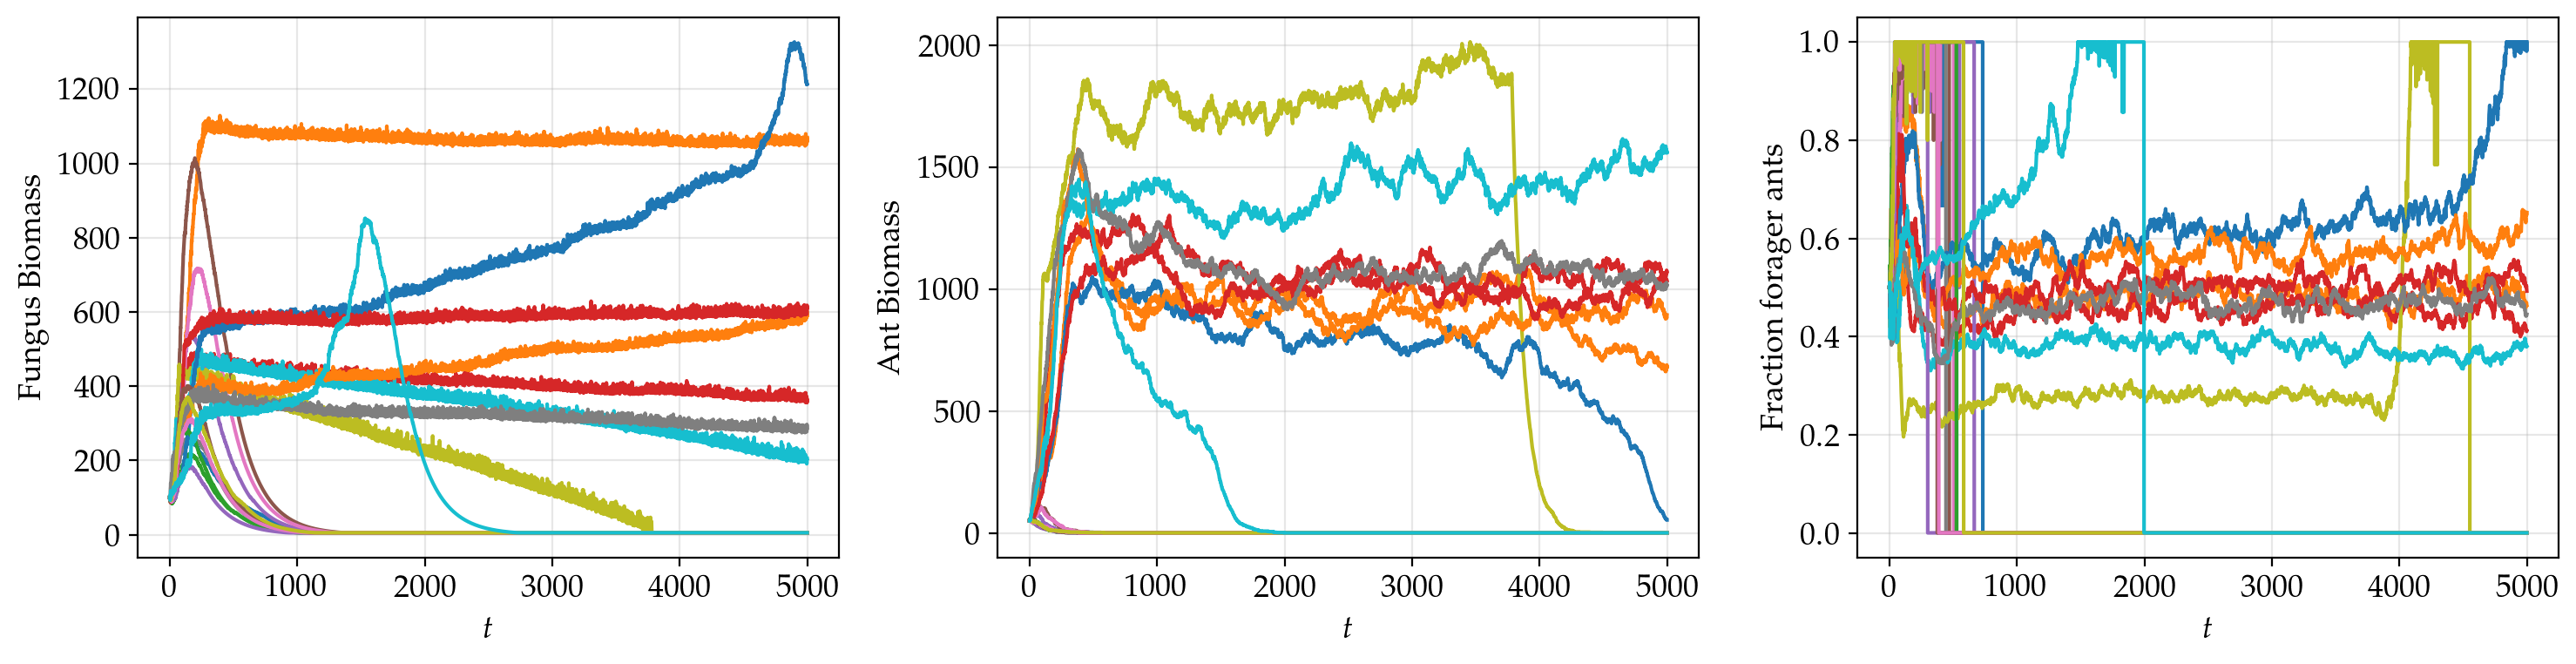

In [356]:
fig = plt.figure(figsize=(15, 4))

for i, measure in enumerate(cols):
    ax = fig.add_subplot(1, 3, i+1)
    for df in dfs[20:40]:
        ax.plot(range(t), df[measure], label=measure)
    ax.set_ylabel(measure)
    ax.set_xlabel("$t$")
    
plt.tight_layout()
plt.show()

mean: 41.32756427266576, stdev: 34.151209430747414


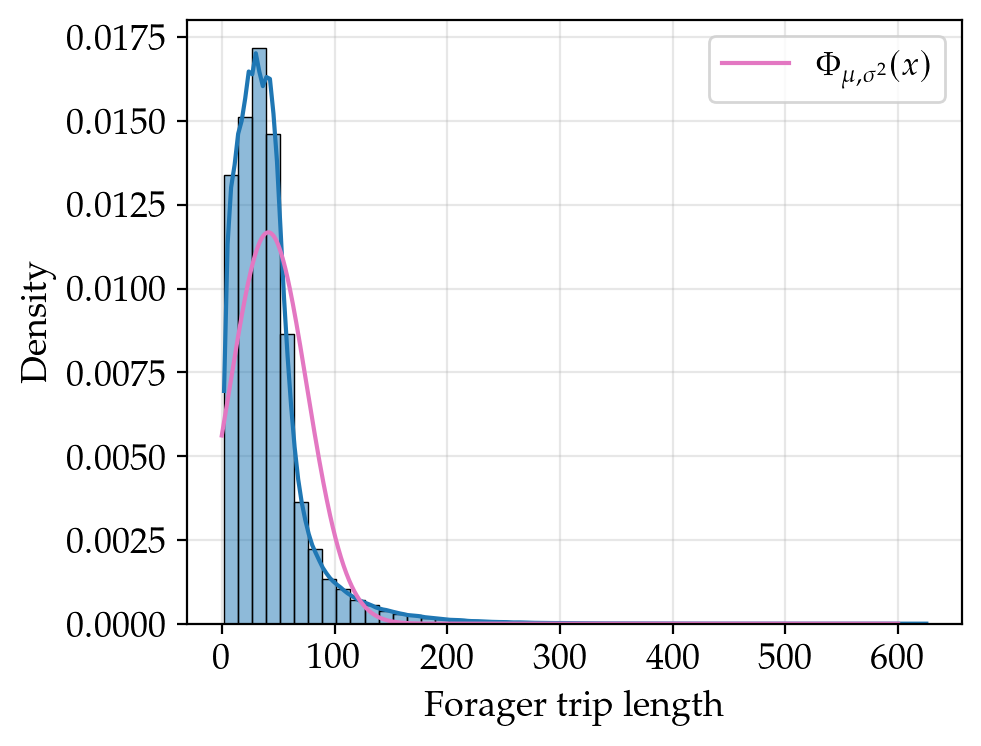

In [381]:
from itertools import chain

def normal_dist(x, mu, sigma):
    return 1/(sigma*np.sqrt(2*np.pi))*np.exp(-(x - mu)**2 / (2*sigma**2))

plt.figure(figsize=(5, 4))
trip_durations = np.array(list(chain.from_iterable(data["trip_durations"])))
mean, stdev = np.mean(trip_durations), np.std(trip_durations)
print(f"mean: {mean}, stdev: {stdev}")

sns.histplot(data=trip_durations, alpha=0.5, bins=50, kde=True, stat="density")
x = np.linspace(0, 600, 1000)
plt.plot(x, normal_dist(x, mean, stdev), color="tab:pink", label="$\\Phi_{\\mu, \\sigma^2}(x)$")
plt.ylabel("Density")
plt.xlabel("Forager trip length")
plt.legend()
plt.show()